In [16]:

import pandas as pd
def map_variable(
    val_or_series,
    mapping = None,
    nulls = None,
    keep = None,
    type_check = int
):
    # Deal with int-as-str issue, although I think low_memory=False should prevent this
    if keep:
        keep += [str(v) for v in keep if isinstance(v, int)]
    if nulls:
        nulls += [str(v) for v in nulls if isinstance(v, int)]
    if mapping:
        for k in list(mapping.keys()):
            if isinstance(k, int):
                mapping[str(k)] = mapping[k]

    def map_val(val):
        if pd.isna(val) or val == " ":
            return pd.NA
            #return None
        if nulls is not None and val in nulls:
            return pd.NA
            #return None
        elif keep is not None:
            if val in keep:
                return type_check(val)
            else:
                return pd.NA
                #return None
        elif mapping is not None:
            if val in mapping:
                return type_check(mapping[val])
            else:
                if nulls is not None: # assume that if we provided explicit nulls, nothing *else* maps to null
                    return type_check(val)
                else:
                    return pd.NA # otherwise, everything else maps to null; pass nulls = {} to avoid this
                    #return None
        else:
            return type_check(val)
        
    if isinstance(val_or_series, pd.Series):
        return val_or_series.apply(map_val)
    else:
        return map_val(val_or_series)
    


def validate_variable(df_var, values=None, min=None, max=None):
    distinct_values = df_var.dropna().unique()
    if len(distinct_values) == 0:
        raise ValueError("No non-missing values to validate in variable!")
    for val in distinct_values:
        if values is not None:
            if val not in values:
                raise ValueError(f"Value {val} not in allowed set of {values}")
        if min is not None:
            if val < min:
                raise ValueError(f"Value {val} less than minimum of {min}")
        if max is not None:
            if val > max:
                raise ValueError(f"Value {val} greater than maximum of {max}")
    return True

def json_to_kwargs(var, json_dict):
    kwargs = json_dict.copy()
    type_check = kwargs.pop("_type_", "int")
    if type_check == "int":
        type_check = int
    elif type_check == "float":
        type_check = float
    elif type_check == "str":
        type_check = str
    else:
        raise ValueError(f"Unsupported type {type_check} for variable {var}")
    kwargs["type_check"] = type_check
    if "mapping" in kwargs:
        mapping = {}
        for k, v in kwargs["mapping"].items():
            mapping[k] = v
            try:
                k2 = int(k)
                mapping[k2] = v
            except ValueError:
                pass
        kwargs["mapping"] = mapping
    kwargs = {k: v for k, v in kwargs.items() if not k.startswith("_")}
    return kwargs


In [17]:
calculations = {
    "white_black_diff": lambda row: (row["therm_whites"] - row["therm_blacks"]),
    "white_hisp_diff": lambda row: (row["therm_whites"] - row["therm_hisp"]),
    "age_group": lambda row: (
        pd.NA if pd.isna(row["age"]) else
        "18-29" if 18 <= int(row["age"]) <= 29 else
        "30-44" if 30 <= int(row["age"]) <= 44 else
        "45-64" if 45 <= int(row["age"]) <= 64 else
        "65+" if int(row["age"]) >= 65 else
        pd.NA
    ),
    "resentment": lambda row: (
        pd.NA if pd.isna(row["special_favors_plus"]) or pd.isna(row["tried_harder_plus"]) or pd.isna(row["past_slavery_minus"]) or pd.isna(row["less_deserve_minus"]) else
        int(row["special_favors_plus"]) + int(row["tried_harder_plus"]) - int(row["past_slavery_minus"]) - int(row["less_deserve_minus"])#+ 12 # if you want a 4-20 scale.
    ),
    "race_edu_block": lambda row: (
        pd.NA if pd.isna(row["college_3"]) or pd.isna(row["race"]) else
        "NonWhite" if row["race"] in ("Black","Hispanic","Other") else
        "WhiteCollege" if row["race"] == "White" and row["college_3"] == 2 else
        "WhiteNonCollege" if row["race"] == "White" and row["college_3"] in (0,1) else
        pd.NA
    ),
    "race_party_block": lambda row: (
        pd.NA if pd.isna(row["race"]) or pd.isna(row["party_7"]) else
        "WhiteRep" if row["race"] == "White" and row["party_7"] in (6,7) else
        "WhiteDem" if row["race"] == "White" and row["party_7"] in (1,2) else
        "WhiteInd" if row["race"] == "White" else
        "NonWhite" if row["race"] in ("Black","Hispanic","Other") else
        pd.NA
    ),
    "vote_prev_vote": lambda row: (
        pd.NA if pd.isna(row["prev_rep_pres"]) or pd.isna(row["vote_rep_pres"]) else
        "Rep-Rep" if row["prev_rep_pres"] == 1 and row["vote_rep_pres"] == 1 else
        "Rep-Dem" if row["prev_rep_pres"] == 1 and row["vote_rep_pres"] == 0 else
        "Dem-Rep" if row["prev_rep_pres"] == 0 and row["vote_rep_pres"] == 1 else
        "Dem-Dem" if row["prev_rep_pres"] == 0 and row["vote_rep_pres"] == 0 else
        pd.NA
    ),
    "party_3": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        "D" if row["party_7"] in (1,2) else
        "R" if row["party_7"] in (6,7) else
        "I" if row["party_7"] in (2,3,4,5,6) else
        pd.NA
    ),
    "party_3_strong": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        "D" if row["party_7"] == 1 else
        "R" if row["party_7"] == 7 else
        "I" if row["party_7"] in (2,3,4,5,6) else
        pd.NA
    ),
    "party_3_lean": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        "D" if row["party_7"] == 1 else
        "R" if row["party_7"] == 7 else
        "I" if row["party_7"] in (2,3,4,5,6) else
        pd.NA
    ),
    "self_dem_diff": lambda row: (
        pd.NA if pd.isna(row["self_assist_blacks"]) or pd.isna(row["dem_assist_blacks"]) else
        row["dem_assist_blacks"] - row["self_assist_blacks"]
    ),
    "self_rep_diff": lambda row: (
        pd.NA if pd.isna(row["self_assist_blacks"]) or pd.isna(row["rep_assist_blacks"]) else
        row["rep_assist_blacks"] - row["self_assist_blacks"]
    )
}

In [18]:

import json
with open("configs/clean_config.json", "r") as f:
    config = json.load(f)

config

{'2000': {'_file_': 'anes2000TS.dta',
  'caseid': 'V000001',
  'weight': {'_source_': 'V000002a', '_type_': 'float'},
  'age': {'_source_': 'V000908',
   'nulls': ['00. NA'],
   'mapping': {'97. 97 and older': 97},
   '_valid_': {'min': 0, 'max': 120}},
  'race': {'_source_': 'V001006a',
   'mapping': {'10. BLACK': 'Black',
    '20. ASIAN': 'Other',
    '30. NATIVE AMERICAN': 'Other',
    '40. HISPANIC OR LATINO': 'Hispanic',
    '50. WHITE': 'White',
    '60. OTHER SPECIFY - MISC.': 'Other',
    '75. OTHER SPECIFY - EAST INDIAN': 'Other',
    '75. OTHER SPECIFY - PACIFIC ISLANDER': 'Other',
    '79. OTHER SPECIFY - MORE THAN 3 MAJOR GR': 'Other',
    "80. OTHER SPECIFY - 'AMERICAN'": 'Other'},
   '_valid_': ['Black', 'White', 'Hispanic', 'Other'],
   '_type_': 'str'},
  'whites_influence': {'_source_': 'V001437',
   'mapping': {'1. TOO MUCH INFLUENCE': 1,
    '2. JUST ABOUT THE RIGHT AMOUNT': 2,
    '3. TOO LITTLE INFLUENCE': 3},
   '_valid_': [1, 2, 3]},
  'blacks_influence': {'_sour

In [19]:
import pandas as pd
import os

def build_dataframe(
        year=None,
        vars=None,
        config=None,
        datapath="data",
        return_raw=False,
        drop_weightless=True,
        calculated=[],
        calculations=None
):
    # fall back on default config
    if config is None:
        with open("configs/clean_config.json", "r") as f:
            config = json.load(f)
    # Need to specify year
    year_config = config.get(str(year), None)
    if year_config is None:
        raise ValueError(f"No configuration found for year {year}")
    # Use all vars for the year if none specified
    vars =  [var for var in year_config.keys() if not var.startswith("_")] if vars is None else vars
    fname = year_config["_file_"]
    if fname.endswith(".dta"):
        raw = pd.read_stata(os.path.join(datapath, fname))
    elif fname.endswith(".csv"):
        raw = pd.read_csv(os.path.join(datapath, fname), low_memory=False)
    # early exit for development
    if return_raw:
        return raw
    # build dataframe
    df = raw[[]].copy()
    df["year"] = year
    for var in vars:
        if var not in year_config:
            continue # this is allowed
        var_config = year_config[var]
        if not var_config:
            pass # skip variable if config is null/None/empty
        elif isinstance(var_config, str):
            df[var] = raw[var_config]
            #df[var] = map_variable(raw[var_config])
        elif isinstance(var_config, dict):
            source = var_config.get("_source_", None)
            kwargs = json_to_kwargs(var, var_config)
            df[var] = map_variable(raw[source], **kwargs)
            # validate if desired
            if "_valid_" in var_config:
                valid = var_config["_valid_"]
                if isinstance(valid, list):
                    validate_variable(df[var], values=valid)
                else:
                    validate_variable(df[var], **valid)
    ## Worry about calculated variables later
    pass
    # drop rows with missing weights if desired
    if drop_weightless and "weight" in df.columns:
        df = df[~df["weight"].isna()]
    # add calculated variables if desired
    if calculated:
        for var in calculated:
            if var not in calculations:
                raise ValueError(f"No calculation found for variable {var}")
            try:
                df[var] = df.apply(calculations[var], axis=1)
            except:
                pass
    # return dataframe
    return df


def build_dataframes(
    years=[2000, 2004, 2008, 2012, 2016, 2020, 2024],
    vars=None,
    config=None,
    datapath="data",
    calculated=[],
    calculations=None
):
    # fall back on default config
    if config is None:
        with open("configs/clean_config.json", "r") as f:
            config = json.load(f)
    # get yearly data
    dfs = []
    for year in years:
        print(year)
        df = build_dataframe(
            year=year,
            vars=vars,
            config=config,
            datapath=datapath,
            calculated=calculated,
            calculations=calculations
        )
        dfs.append(df)
    # concatenate all dataframes
    df_all = pd.concat(dfs, ignore_index=True).convert_dtypes(dtype_backend="numpy_nullable")
    return df_all

In [20]:
var = "V001508"
year = 2000
test = build_dataframe(year=year,vars = [var], return_raw=True)
test[var].value_counts(dropna=False).sort_index()

V001508
0. NA. INAP, no Post interview    252
1. AGREE STRONGLY                 561
2. AGREE SOMEWHAT                 491
3. NEITHER AGREE NOR DISAGREE     188
4. DISAGREE SOMEWHAT              212
5. DISAGREE STRONGLY               89
8. DK                               9
9. RF                               5
Name: count, dtype: int64

In [21]:
var = "tried_harder_plus"
year = 2000
test = build_dataframes(
    years = [year],
    vars = [var]
)
test[var].value_counts(dropna=False).sort_index()

2000


tried_harder_plus
1       351
2       427
3       251
4       331
5       172
<NA>    275
Name: count, dtype: Int64

In [22]:
test = build_dataframes(
    vars = [
        "caseid",
        "weight",
        "age",
        "race",
        "whites_influence",
        "blacks_influence",
        "hispanics_influence",
        "party_7",
        "less_immig",
        "college_3",
        "therm_hisp",
        "therm_blacks",
        "therm_whites",
        "self_assist_blacks",
        "dem_assist_blacks",
        "rep_assist_blacks",
        "special_favors_plus",
        "past_slavery_minus",
        "less_deserve_minus",
        "tried_harder_plus"
    ],
    calculated=[
        "party_3",
        "party_3_strong",
        "party_3_lean",
        "resentment",
        "race_edu_block",
        "race_party_block",
        "self_dem_diff",
        "self_rep_diff",
        "self_rep_diff",
        "white_black_diff",
        "white_hisp_diff"
    ],
    calculations=calculations
)
for year in [2000, 2004, 2008, 2012, 2016, 2020, 2024]:
    dta = test[test["year"] == year]
    print(year)
    print(dta["resentment"].value_counts(dropna=False).sort_index())

2000
2004
2008
2012
2016


/tmp/ipykernel_3383426/589758574.py:26: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  raw = pd.read_stata(os.path.join(datapath, fname))


2020
2024
2000
resentment
-8      104
-7       92
-6       80
-5      120
-4      128
-3      125
-2      139
-1      134
0       185
1        86
2        99
3        55
4        73
5        41
6        18
7        13
8        22
<NA>    293
Name: count, dtype: Int64
2004
resentment
-8       64
-7       49
-6       52
-5       82
-4      108
-3       84
-2       99
-1       90
0       108
1        65
2        64
3        47
4        45
5        22
6        26
7        15
8        26
<NA>    166
Name: count, dtype: Int64
2008
resentment
-8      131
-7       91
-6      101
-5      140
-4      164
-3      174
-2      215
-1      246
0       248
1       144
2        96
3        81
4        92
5        54
6        31
7        25
8        26
<NA>     43
Name: count, dtype: Int64
2012
resentment
-8      508
-7      305
-6      311
-5      365
-4      476
-3      429
-2      497
-1      428
0       636
1       329
2       303
3       253
4       222
5       139
6        89
7        72
8       

/tmp/ipykernel_1592355/975697442.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


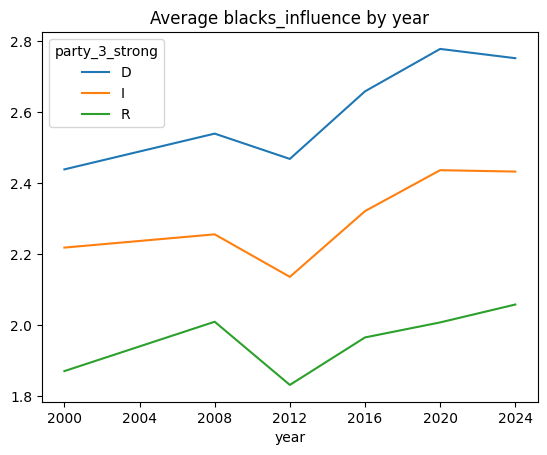

In [34]:
## Compute weighted mean
import matplotlib.pyplot as plt
def weighted_mean(data, val_col, weight="weight"):
    #print(type(data))
    nomiss = data[data[val_col].notna() & data[weight].notna()]
    if len(nomiss) == 0:
        raise ValueError("No valid data to compute weighted mean")
    return (nomiss[val_col] * nomiss[weight]).sum() / nomiss[weight].sum()


## Plot a weighted aggregate function of a variable over time, usually weighted mean, optional grouping
def plot_weight_agg_over_time(
    df,
    var,
    weight = "weight",
    time = "year",
    title = None,
    groupby = None,
    agg = weighted_mean,
):
    nomiss = df[df[var].notna() & df[weight].notna()]
    if groupby is not None:
        for g in groupby:
            nomiss = nomiss[nomiss[g].notna()]
    if len(nomiss) == 0:
        raise ValueError("No valid data to plot")
    
    if groupby is not None:
        nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()
    else:
        nomiss.groupby(time).apply(agg, var, weight=weight).plot()

    if title is None:
        title = f"Average {var} by {time}"
    plt.title(title)
    plt.xticks(df[time].unique())
    plt.show()

plot_weight_agg_over_time(test, "blacks_influence", groupby=["party_3_strong"])